# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: This is a classification problem. Since we are going to identify students who might need early intervention, and thus students are classified into two groups.**

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = len(student_data.index)

# TODO: Calculate number of features
n_features = len(student_data.columns[:-1])

# TODO: Calculate passing students
n_passed = len(student_data[student_data.passed == 'yes'].index)

# TODO: Calculate failing students
n_failed = len(student_data[student_data.passed == 'no'].index)

# TODO: Calculate graduation rate
grad_rate = n_passed/float(n_students)*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

C:\Users\richa\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


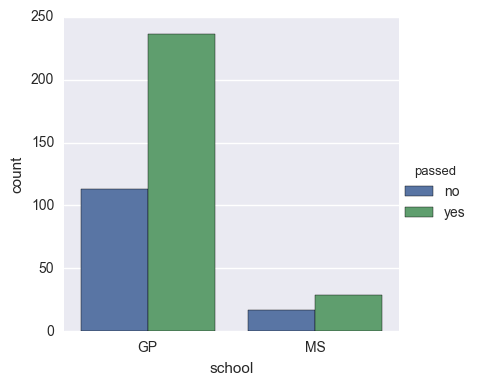

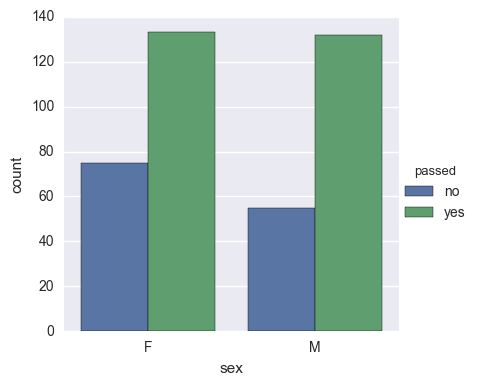

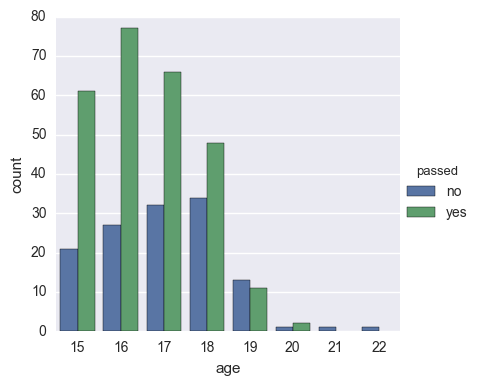

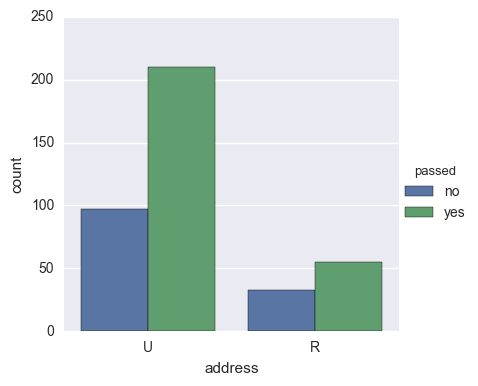

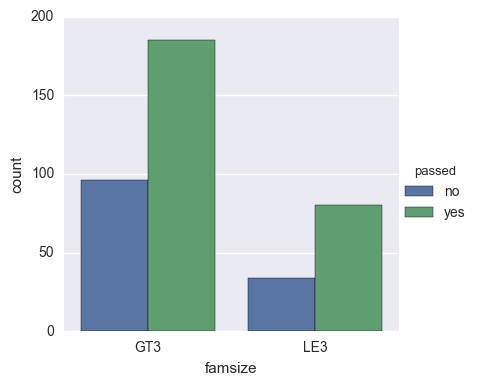

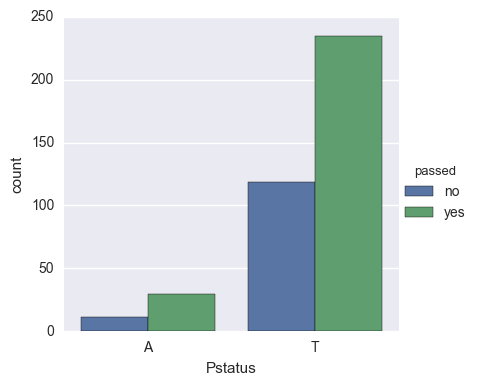

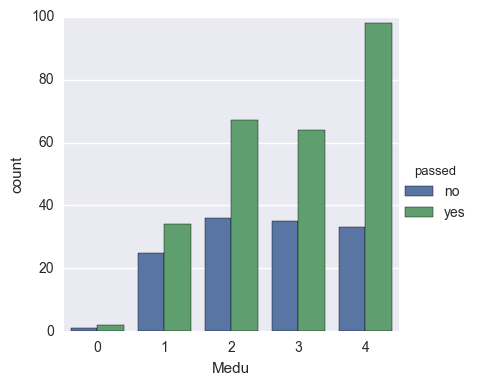

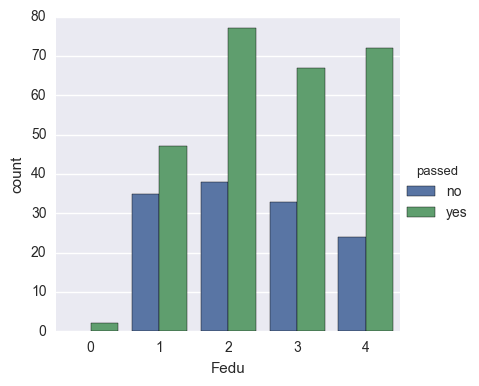

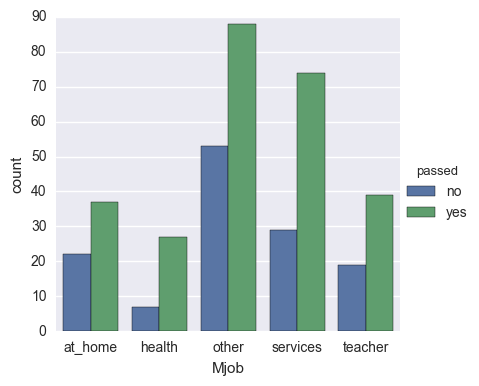

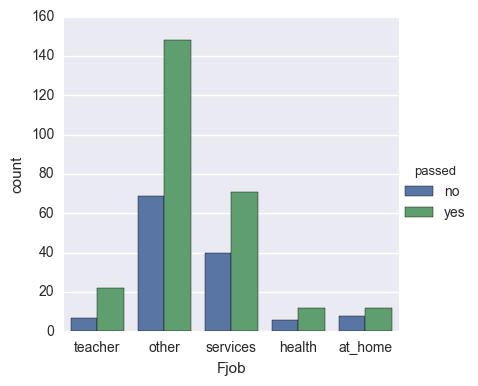

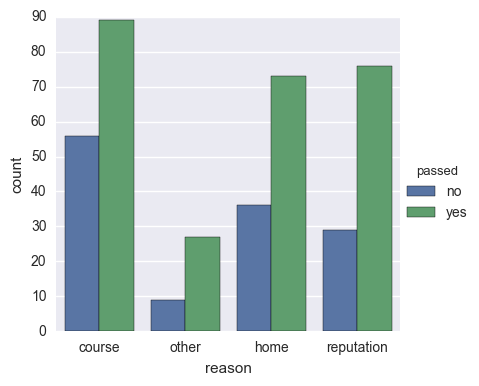

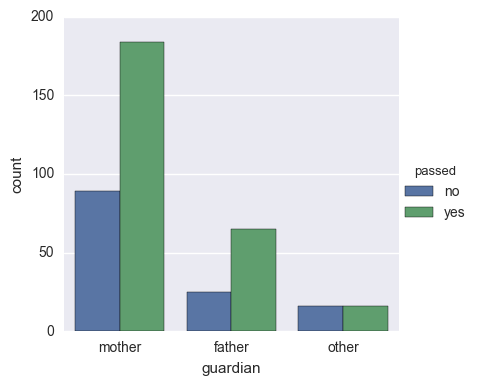

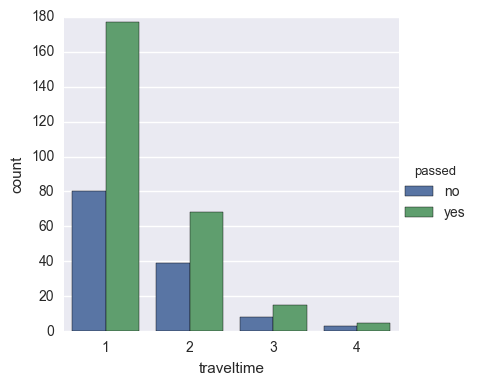

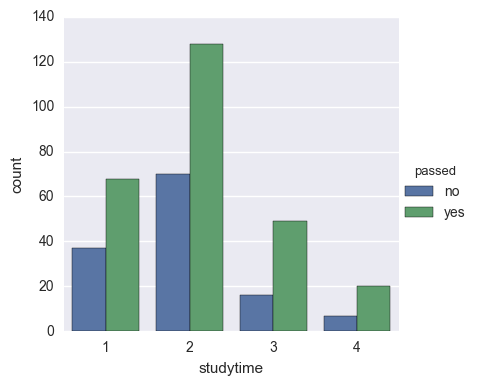

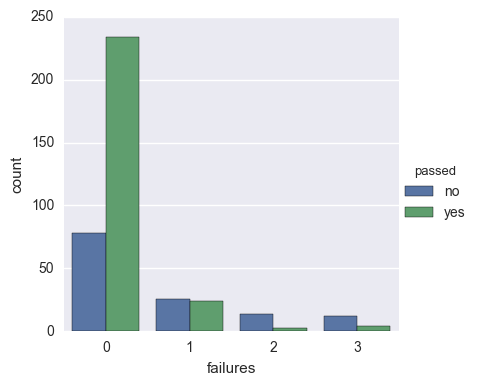

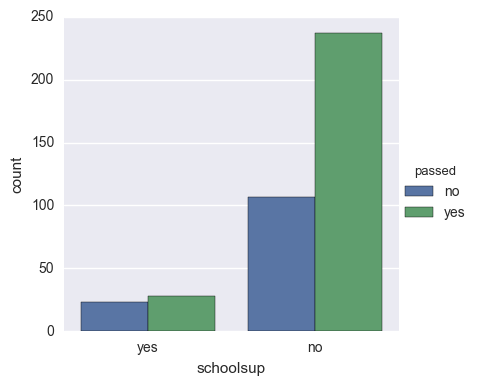

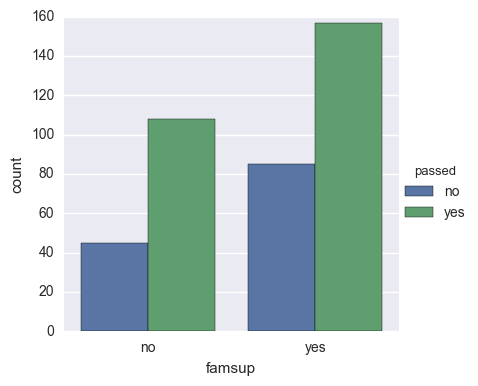

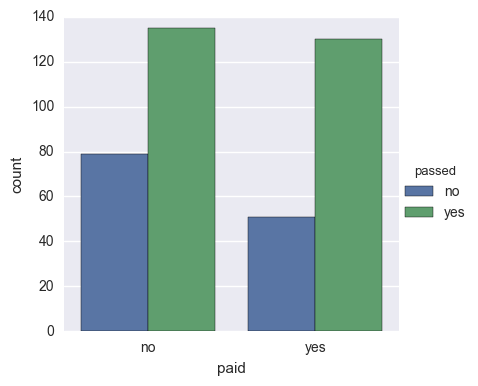

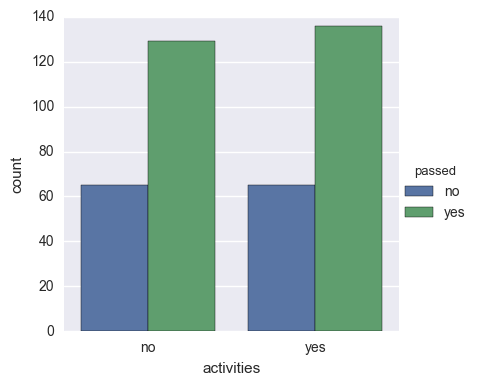

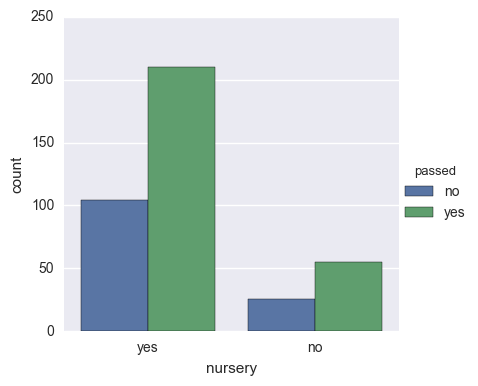

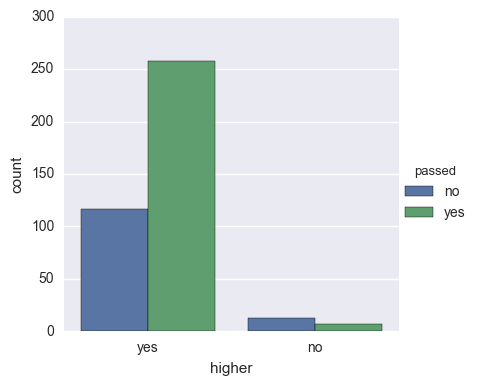

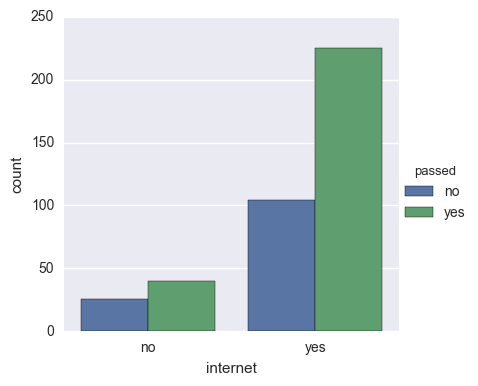

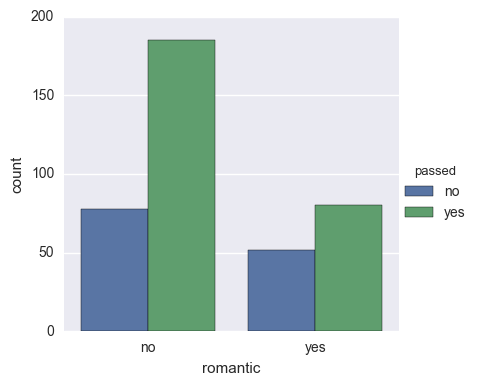

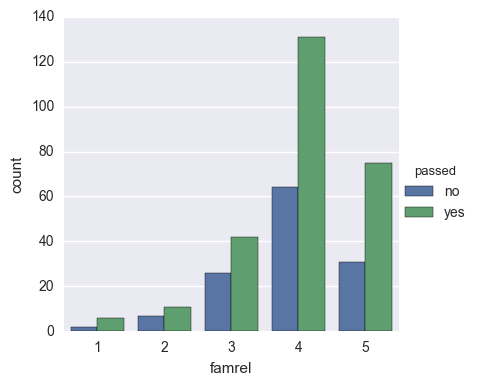

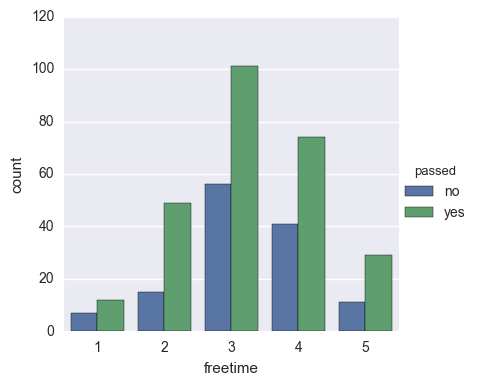

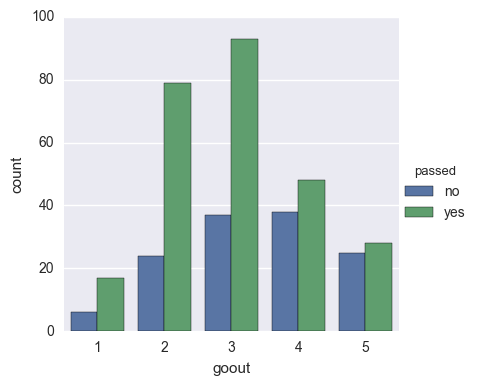

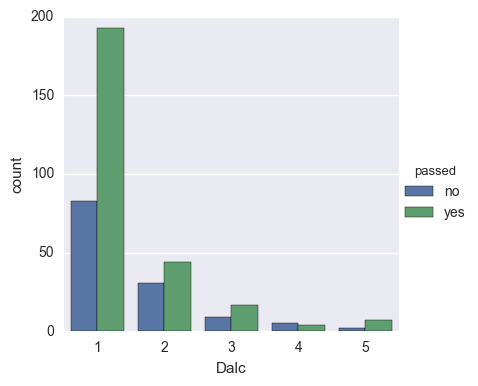

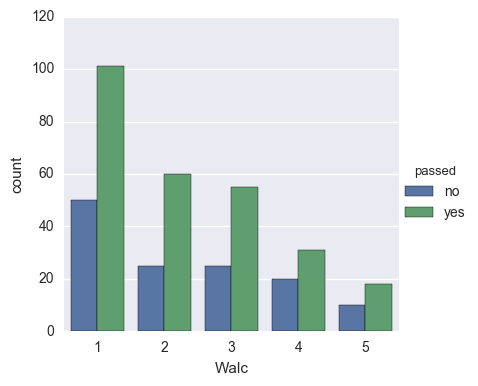

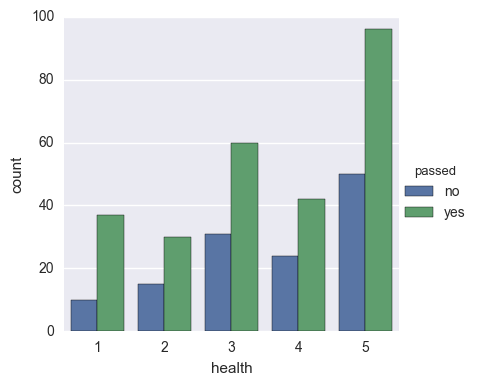

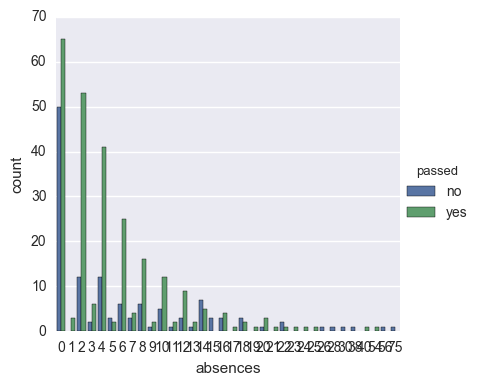

In [3]:
%matplotlib inline
import seaborn as sns

# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

for features in X_all.head():
    sns.factorplot(features, data=student_data, hue='passed', kind="count")


### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=num_test, random_state=0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: Logistic regression, decision tree, and support vector machines are suitable for this classification problem. 
Logistic regression has medical applications such as to predict whether a patient has heart disease based on the characteristics of the patient [1]. Logistic regression has a fast training times and simple (less prone to over-fitting). It performs well when the data can be linearly separated, and is robust to noisy data. The model can be too simple (tradeoff in accuracy), and it may work poorly when the data cannot be separated by one decision boundary. Since logistic regression is simple, it would be nice to use logistic regression to train a baseline learner such that we can rank other models by comparing with the baseline learner. 

Decision tree is logical based learning, and it can applied in physics to detect particles [2]. Since it is based on logic learning to gain the information, it can help us to achieve better understanding about the decision that the alogrithm made. It works well even there is no single decision boundary since it is not based on linearity of the data. It may be costly to train the logical learner, and it performs poorly with many class and small data. In our case, we work on two class classification and the data size is not small, the decision tree may work well.

SVM is widely used in protein classification [3]. It performance depends on the data. For the data that can be linearly separated into different classes, SVM can perform pretty well. If the data is non-linear separable, kernel function can be applied to capture the nonlinearity. This requires the domain knowledge of the data, and the performance will depends on the choice of kernel function. However, if the data is not separated, soft margin SVM can be applied to allow wrong classifications for some data by introducing penalty in the minimization of the margin. Although we don't know the linearity of the data, we can apply the soft-margin SVM with kernel trick to train the learner. Thus, SVM is still be a good candidate. 

[1] Truett et al., J Chronic Dis. 1967 20(7):511-24

[2] Bowser-chao et al., Physical Review D, 1993 47(5):1900

[3] Leslie et al., Proceedings of the Pacific Symposium on Biocomputing, 2002. pp. 564–575
**

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
from sklearn.linear_model import LogisticRegression
# from sklearn import model_B
from sklearn import tree
# from skearln import model_C
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state = 1)
clf_B = tree.DecisionTreeClassifier(random_state = 1)
clf_C = SVC(random_state = 1)

# TODO: Set up the training set sizes
X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train[:]
y_train_300 = y_train[:]

In [8]:
# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)

train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)

train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)

Training a LogisticRegression using a training set size of 100. . .
Trained model in 0.0020 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8571.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7612.
Training a LogisticRegression using a training set size of 200. . .
Trained model in 0.0010 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8380.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7794.
Training a LogisticRegression using a training set size of 300. . .
Trained model in 0.0050 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8381.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7910.


In [9]:
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)

train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)

train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.6496.
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0010 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7231.
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0020 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7107.


In [10]:
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)

train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)

train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

Training a SVC using a training set size of 100. . .
Trained model in 0.0020 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8591.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7838.
Training a SVC using a training set size of 200. . .
Trained model in 0.0040 seconds
Made predictions in 0.0030 seconds.
F1 score for training set: 0.8693.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.7755.
Training a SVC using a training set size of 300. . .
Trained model in 0.0080 seconds
Made predictions in 0.0080 seconds.
F1 score for training set: 0.8692.
Made predictions in 0.0030 seconds.
F1 score for test set: 0.7586.


In [11]:
print "F1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

F1 score for predicting all "yes" on test set: 0.7662


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - LogisticRegression**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.002                   | 0.000                  | 0.8571           | 0.7612          |
| 200               | 0.003                   | 0.000                  | 0.8380           | 0.7794          |
| 300               | 0.004                   | 0.000                  | 0.8381           | 0.7910          |

** Classifer 2 - DecisionTreeClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.001                   | 0.0000                 | 1.000            | 0.6496          |
| 200               | 0.002                   | 0.0000                 | 1.000            | 0.7231          |
| 300               | 0.002                   | 0.0000                 | 1.000            | 0.7107          |

** Classifer 3 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.003                   | 0.001                  | 0.8591           | 0.7838          |
| 200               | 0.004                   | 0.002                  | 0.8693           | 0.7755          |
| 300               | 0.010                   | 0.003                  | 0.8692           | 0.7586          |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: SVC is the best model, since it can achieve a higher F1 score than bench F1 score (0.7662) for predicting the test sample with only 100 and 200 training data. Although its training and predicting times are a bit longer than other classifiers, the tradeoff is still acceptable.**

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: The SVM takes data about previous students (age, gender, family, etc), and uses them to create a function that draws a boundary between the students who passed and those who didn't. The boundary should be drawn so as to maximize the distance between it and its closet students. Often, though, it's not easy to draw a decision boundary in low dimensions (i.e., small number of student's features), so the SVM separates the passing and failing students in higher dimensions by considering more student's features (more freedom for decision boundary). Using this function created with students we already know passed or not, the SVM can look at new students' data (age, gender, family, etc) and predict whether students can pass or not.**

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [12]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.svm import SVC

# TODO: Create the parameters list you wish to tune
C_range = np.logspace(-3, 3, 15)
gamma_range = np.logspace(-5, 4, 15)
parameters = dict(gamma=gamma_range, C=C_range)

# TODO: Initialize the classifier
clf = SVC(degree= 2, random_state=1)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer, verbose=1, cv= 4)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
best_params = grid_obj.best_params_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

print "The best parameters are {}".format(best_params)

from IPython.display import display
display(pd.DataFrame(grid_obj.grid_scores_))

Fitting 4 folds for each of 225 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    8.3s


Made predictions in 0.0070 seconds.
Tuned model has a training F1 score of 0.9537.
Made predictions in 0.0020 seconds.
Tuned model has a testing F1 score of 0.7945.
The best parameters are {'C': 1.0, 'gamma': 0.071968567300115291}


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:    9.5s finished


,parameters,mean_validation_score,cv_validation_scores
0,"{u'C': 0.001, u'gamma': 1e-05}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
1,"{u'C': 0.001, u'gamma': 4.39397056076e-05}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
2,"{u'C': 0.001, u'gamma': 0.000193069772888}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
3,"{u'C': 0.001, u'gamma': 0.000848342898244}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
4,"{u'C': 0.001, u'gamma': 0.00372759372031}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
5,"{u'C': 0.001, u'gamma': 0.0163789370695}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
6,"{u'C': 0.001, u'gamma': 0.0719685673001}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
7,"{u'C': 0.001, u'gamma': 0.316227766017}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
8,"{u'C': 0.001, u'gamma': 1.38949549437}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
9,"{u'C': 0.001, u'gamma': 6.10540229659}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"


In [13]:
# Try normalizer
from sklearn import preprocessing
X_normalized_train = preprocessing.normalize(X_train, norm='l2')
X_normalized_test = preprocessing.normalize(X_test, norm="l2")

grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, verbose=1, cv=4)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_normalized_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
best_params = grid_obj.best_params_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_normalized_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_normalized_test, y_test))

print "The best parameters are {}".format(best_params)

from IPython.display import display
display(pd.DataFrame(grid_obj.grid_scores_))

Fitting 4 folds for each of 225 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.1s


Made predictions in 0.0060 seconds.
Tuned model has a training F1 score of 0.8369.
Made predictions in 0.0010 seconds.
Tuned model has a testing F1 score of 0.7972.
The best parameters are {'C': 138.94954943731361, 'gamma': 0.071968567300115291}


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:    7.0s finished


,parameters,mean_validation_score,cv_validation_scores
0,"{u'C': 0.001, u'gamma': 1e-05}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
1,"{u'C': 0.001, u'gamma': 4.39397056076e-05}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
2,"{u'C': 0.001, u'gamma': 0.000193069772888}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
3,"{u'C': 0.001, u'gamma': 0.000848342898244}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
4,"{u'C': 0.001, u'gamma': 0.00372759372031}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
5,"{u'C': 0.001, u'gamma': 0.0163789370695}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
6,"{u'C': 0.001, u'gamma': 0.0719685673001}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
7,"{u'C': 0.001, u'gamma': 0.316227766017}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
8,"{u'C': 0.001, u'gamma': 1.38949549437}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"
9,"{u'C': 0.001, u'gamma': 6.10540229659}",0.814227,"[0.8125, 0.8125, 0.816, 0.816]"


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: The final model's F<sub>1</sub> score for training and testing are .8369 and .7972. The score is a bit better than the untuned model, which suggest the default parameters in SVC is a also a good set of parameters.**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.